# Example notebook

Displays how the EM module works on an RIR stored in example.mat in matlab format.

In [1]:
from __future__ import print_function
import numpy as np
from IPython.display import clear_output
import sys

from scipy.signal import lfilter, stft
from scipy.linalg import toeplitz
from scipy.signal import convolve2d, correlate2d
import time
import scipy.io

import matplotlib.pyplot as plt

if sys.version_info.major == 3:
    import _pickle as pickle
else:
    import cPickle as pickle
    
import EM

In [2]:
# Definition of the progress bar function for better readability
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [44]:
# Definition of the relative distance function, excluding the first frequency bin
def relative(x,y):
    if isinstance(x, list):
        res = []
        for x_i in x:
            res.append(relative(x_i, y))
        return res
    else:
        x_norm = x/np.sqrt(np.sum(np.square(x)))
        y_norm = y/np.sqrt(np.sum(np.square(y)))
        quot = np.abs(x[1:]-y[1:])/y[1:]
        return np.mean(quot)
    
# Definition of the decibel function
def db(x):
    if isinstance(x, list):
        res = []
        for x_i in x:
            res.append(db(x_i))
        return res
    else:
        return 10*np.log10(x)

# Definition of a delta function
delta = np.zeros(200)
delta[0] = 1

### Load example RIR
Load an exemple dictionnary containing a RIR and the corresponding true parameters with pickle.

In [23]:
filename = "examples/absorption/abs7_seed0.pkl"

In [24]:
try:
    with open(filename, 'rb') as in_file:
        dic = pickle.load(in_file)
except UnicodeDecodeError:
    with open(filename, 'rb') as in_file:
        dic = pickle.load(in_file, encoding="latin1")

In [25]:
h = dic["h"] # Example RIR

### Initialize EM algorithm

In [75]:
algo = EM.EM(h)

Initializing EM algorithm
la init = 5.645029269476762e-06

Updating R

Updating mu
Log-probability difference = -96175.89190557358


### Iterate 100 times the expectation and maximization steps

In [76]:
n_iter = 100

for i in range(n_iter):
    algo.iteration()
    update_progress(i / n_iter)

update_progress(1)

Progress: [####################] 100.0%


### Plot results

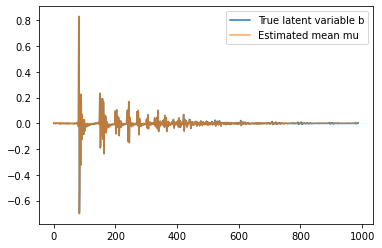

In [77]:
plt.plot(dic["h"]-dic["w"], label="True latent variable b")
plt.plot(algo.mu, alpha=0.7, label="Estimated mean mu")
plt.legend()
plt.show()

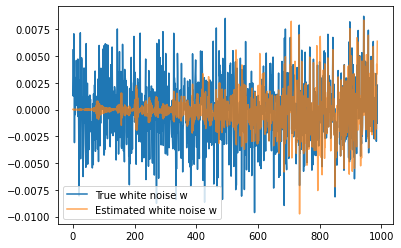

In [78]:
plt.plot(dic["w"], label="True white noise w")
plt.plot(algo.w, alpha=0.7, label="Estimated white noise w")
plt.legend()
plt.show()

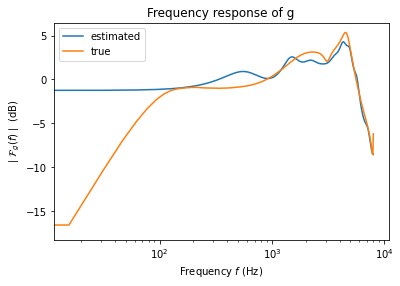

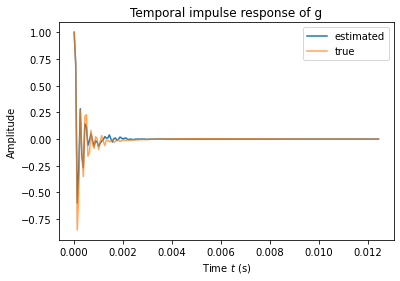

In [79]:
N_FFT = 1024
f = plt.figure()
axes = f.gca()

# True frequency response of g
fft_true = np.abs(np.fft.fft(dic["rif_g"],N_FFT))
fft_true_norm = fft_true/np.sqrt(np.sum(np.square(fft_true)))

# Estimated frequency response of g
fft_est = np.abs(1/np.fft.fft(algo.A,N_FFT))
fft_est_norm = fft_est/np.sqrt(np.sum(np.square(fft_est)))

# Show the true and estimated frequency responses in dB
plt.plot(dic['fs']*np.arange(N_FFT/2)/N_FFT,db(fft_est[:int(N_FFT/2)]))
plt.plot(dic['fs']*np.arange(N_FFT/2)/N_FFT,db(fft_true[:int(N_FFT/2)]))
plt.legend(["estimated", "true"])
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("$\mid \mathcal{F}_g(f) \mid$ (dB)")
plt.title("Frequency response of g")
axes.set_xscale("log")
plt.show()

#Show the corresponding temporal responses
plt.plot(1/dic['fs']*np.arange(200),lfilter([1], algo.A, delta))
plt.plot(1/dic['fs']*np.arange(200),dic["rif_g"], alpha=0.7)
plt.legend(["estimated", "true"])
plt.xlabel("Time $t$ (s)")
plt.ylabel("Amplitude")
plt.title("Temporal impulse response of g")
plt.show()

### Show convergence with iterations

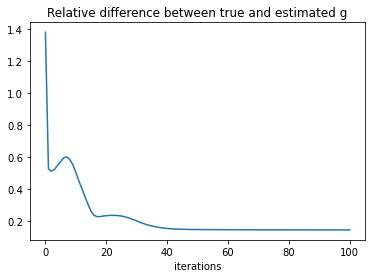

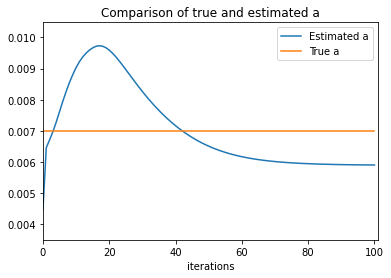

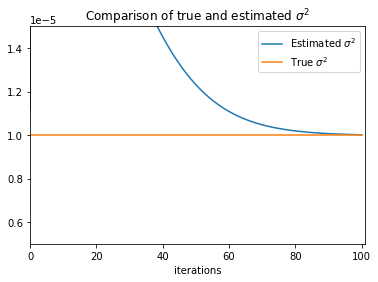

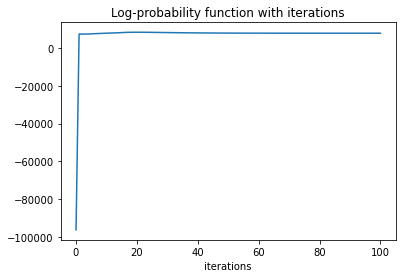

In [80]:
plt.plot(relative([np.abs(1/np.fft.fft(x_i,258)) for x_i in algo.A_list], np.abs(np.fft.fft(dic["rif_g"],258))))
plt.title("Relative difference between true and estimated g")
plt.xlabel('iterations')
plt.show()

plt.plot(algo.a_list, label="Estimated a")
a_true = 3*np.log(10)/(dic['T60']*dic['fs'])
plt.plot(a_true*np.ones(len(algo.a_list)), label="True a")
plt.xlabel('iterations')
plt.axis([0, len(algo.a_list), a_true/2, 1.5*a_true])
plt.legend()
plt.title("Comparison of true and estimated a")
plt.show()

plt.plot(algo.sigma2_list, label="Estimated $\sigma^2$")
plt.plot(dic['sigma2']*np.ones(len(algo.sigma2_list)), label="True $\sigma^2$")
plt.xlabel('iterations')
plt.axis([0, len(algo.sigma2_list), dic['sigma2']/2, 1.5*dic['sigma2']])
plt.legend()
plt.title("Comparison of true and estimated $\sigma^2$")
plt.show()

plt.plot(algo.LP_list)
plt.title("Log-probability function with iterations")
plt.xlabel('iterations')
plt.show()